In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from mizani.breaks import date_breaks
from mizani.formatters import date_format

%matplotlib inline

np.random.seed(11132009)

## 1- What insights can we find by analyzing variable trends over the years?

In [15]:
data_1 = pd.read_csv("../Data/data_modified.csv")
data_1.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,explicit,key,mode,year,name,artists,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,0.995,0.514,172133,0.2560,0.00000,0.3490,-15.145,0,0.0871,79.467,0.574,0,0,1,1921,Si J'avais Su,['Alice Cocéa'],NaN,NaN,NaN
1,0.994,0.426,177733,0.2260,0.00000,0.2350,-16.126,0,0.0693,73.630,0.552,0,9,1,1921,Elle Porte Un Nom Charmant,['André Urban'],NaN,NaN,NaN
2,0.971,0.540,122000,0.0848,0.00196,0.0887,-16.055,0,0.0750,100.296,0.527,0,5,0,1921,A Ballynure Ballad,['Christopher Lynch'],NaN,NaN,NaN
3,0.950,0.607,163200,0.1380,0.00000,0.1140,-15.683,0,0.1570,113.282,0.511,0,3,1,1921,I Met Her In The Garden Where The Praties Grow,['Christopher Lynch'],NaN,NaN,NaN
4,0.969,0.344,120067,0.1310,0.00000,0.1450,-14.261,0,0.0616,178.212,0.257,0,10,0,1921,Just A Little Bit Of Heaven,['Christopher Lynch'],NaN,NaN,NaN


In [21]:
## DATA AGGREGATION ##

# CONTINUOUS VARIABLES #

cont_features_1 = ["acousticness", 
                   "danceability", 
                   "duration_ms", 
                   "energy", 
                   "instrumentalness", 
                   "liveness", 
                   "loudness", 
                   "popularity", 
                   "speechiness", 
                   "tempo", 
                   "valence"]
data_agg_cols_1 = ["year"] + cont_features_1
data_agg_1 = pd.DataFrame(columns = data_agg_cols_1)

# CATEGORICAL VARIABLES #

#Kyes
key_cols_1 = ["year", "key", "number", "percentage"]
key_distro_1 = pd.DataFrame(columns = key_cols_1)

#Mode
mode_cols_1 = ["year", "mode", "number", "percentage"]
mode_distro_1 = pd.DataFrame(columns = mode_cols_1)

#Explicit
explicit_cols_1 = ["year", "explicit", "number", "percentage"]
explicit_distro_1 = pd.DataFrame(columns = explicit_cols_1)

In [98]:
# Loop through each year
for i in range (1921, 2021):
    # Create a temporary dataframe for the year
    inYr = data_1["year"] == i
    yrDF = data_1.loc[inYr]
    
    ### CONTINUOUS VARIABLES ###
    
    data_agg_1 = data_agg_1.append(pd.DataFrame({"year" : [float(i)],
                                                 "acousticness": yrDF["acousticness"].mean(), 
                                                 "danceability": yrDF["danceability"].mean(), 
                                                 "duration_ms": yrDF["duration_ms"].mean(), 
                                                 "energy": yrDF["energy"].mean(), 
                                                 "instrumentalness": yrDF["instrumentalness"].mean(), 
                                                 "liveness": yrDF["liveness"].mean(), 
                                                 "loudness": yrDF["loudness"].mean(), 
                                                 "popularity": yrDF["popularity"].mean(), 
                                                 "speechiness": yrDF["speechiness"].mean(), 
                                                 "tempo": yrDF["tempo"].mean(), 
                                                 "valence": yrDF["valence"].mean()}))
    
    #### KYES ####
    
    # Count number of times each key is used in the year
    num_keys = np.array([0] * 12)
    
    for j in yrDF['key']:
        num_keys[j] = num_keys[j] + 1
    
    # Calculate percentage for each key
    percent_keys = num_keys / yrDF.shape[0]
    
    # Add each year/key pair to the key_distro_1 DF
    for j in range (0, 12):
        key_distro_1 = key_distro_1.append(pd.DataFrame({"year":[i],
                                                         "key": [j],
                                                         "number": [num_keys[j]],
                                                         "percentage": [percent_keys[j]]}))
        
    #### MODES ####
    
    # Count number of times each mode is used in the year
    num_modes = np.array([0] * 2)
    
    for j in yrDF['mode']:
        num_modes[j] = num_modes[j] + 1
    
    # Calculate percentage for each mode
    percent_modes = num_modes / yrDF.shape[0]
    
    # Add each year/mode pair to the mode_distro_1 DF
    for j in range (0, 2):
        mode_distro_1 = mode_distro_1.append(pd.DataFrame({"year":[i],
                                                           "mode": [j],
                                                           "number": [num_modes[j]],
                                                           "percentage": [percent_modes[j]]}))
        
    #### EXPLICIT ####
    
    # Count number of times a song is explicit or not
    num_explicit = np.array([0] * 2)
    
    for j in yrDF['explicit']:
        num_explicit[j] = num_explicit[j] + 1
    
    # Calculate percentage per year a song is explicit
    percent_explicit = num_explicit / yrDF.shape[0]
    
    # Add each year/explicit pair to the explicit_distro_1 DF
    for j in range (0, 2):
        explicit_distro_1 = explicit_distro_1.append(pd.DataFrame({"year":[i],
                                                           "explicit": [j],
                                                           "number": [num_explicit[j]],
                                                           "percentage": [percent_explicit[j]]}))

# Makes a new column with years stored as floats
# This is useful for plotting cleaner graphs
data_agg_1["yr_num"] = pd.to_numeric(data_agg_1["year"])
key_distro_1["yr_num"] = pd.to_numeric(key_distro_1["year"])
mode_distro_1["yr_num"] = pd.to_numeric(mode_distro_1["year"])
explicit_distro_1["yr_num"] = pd.to_numeric(explicit_distro_1["year"])

In [55]:
# data_agg_1.to_csv('data_yearly_avg.csv', index=False)
# explicit_distro_1.to_csv('data_yearly_explicit.csv', index=False)
# mode_distro_1.to_csv('data_yearly_mode.csv', index=False)
# key_distro_1.to_csv('data_yearly_key.csv', index=False)

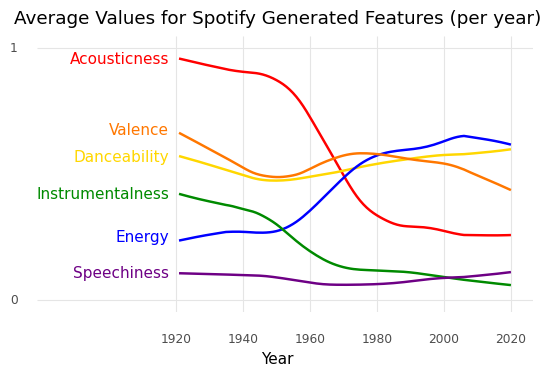

<ggplot: (183759050999)>

In [227]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "acousticness"), color='red', span=.3, se=False)
 + annotate("text", label="Acousticness", x = 1918.0, y=0.96, color='red', ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "danceability"), color='#FFD700', size=1, span=.3, se=False)
 + annotate("text", label="Danceability", x = 1918.0, y=0.57, color='#FFD700', ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "energy"), color='blue', span=.3, se=False)
 + annotate("text", label="Energy", x = 1918.0, y=0.25, color='blue', ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "instrumentalness"), color='#008a00', span=.3, se=False)
 + annotate("text", label="Instrumentalness", x = 1918.0, y=0.42, color='#008a00', ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "speechiness"), color='#6e0085', span=.3, se=False)
 + annotate("text", label="Speechiness", x = 1918.0, y=0.105, color='#6e0085', ha="right" )
 + geom_smooth(aes(x = "yr_num", y = "valence"), color='#ff7700', span=.3, se=False)
 + annotate("text", label="Valence", x = 1918.0, y=0.675, color='#ff7700', ha="right" )
 + scale_x_continuous(limits=(1885.5,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(0,1), breaks=[0,1])
 + theme_minimal()
 + theme(panel_grid_minor=element_blank())
 + ggtitle("Average Values for Spotify Generated Features (per year)")
 + labs(x="Year", y="")
 + coord_fixed(75)
)

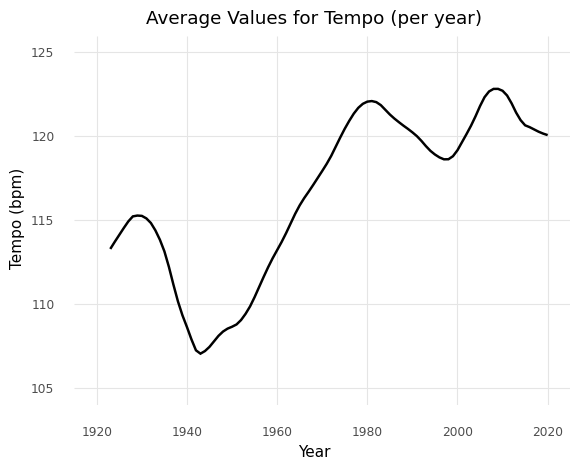

<ggplot: (183758865737)>

In [281]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "tempo"), span=.125, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(105,125))
 + theme_minimal()
 + theme(panel_grid_minor=element_blank())
 + ggtitle("Average Values for Tempo (per year)")
 + labs(x="Year", y="Tempo (bpm)")
)

In [259]:
data_agg_1["duration_min"] = data_agg_1["duration_ms"].div(60000)


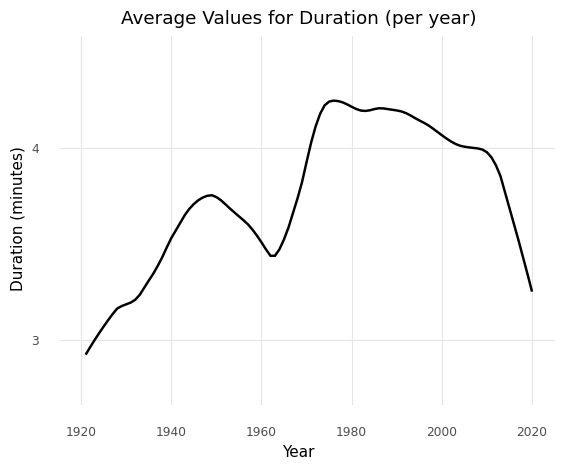

<ggplot: (183761971285)>

In [283]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "duration_min"), span=.15, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + scale_y_continuous(limits=(2.75,4.5), breaks = [3,4])
 + theme_minimal()
 + theme(panel_grid_minor=element_blank())
 + ggtitle("Average Values for Duration (per year)")
 + labs(x="Year", y="Duration (minutes)")
)

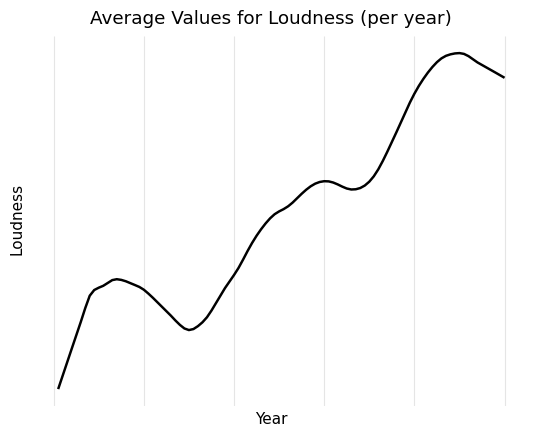

<ggplot: (183758942525)>

In [294]:
(ggplot(data_agg_1) 
 + geom_smooth(aes(x = "yr_num", y = "loudness"), span=.15, se=False)
 + scale_x_continuous(limits=(1920,2020), breaks = range(1920,2021,20))
 + theme_minimal()
 + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(), axis_text=element_blank())
 + ggtitle("Average Values for Loudness (per year)")
 + labs(x="Year", y="Loudness")
)

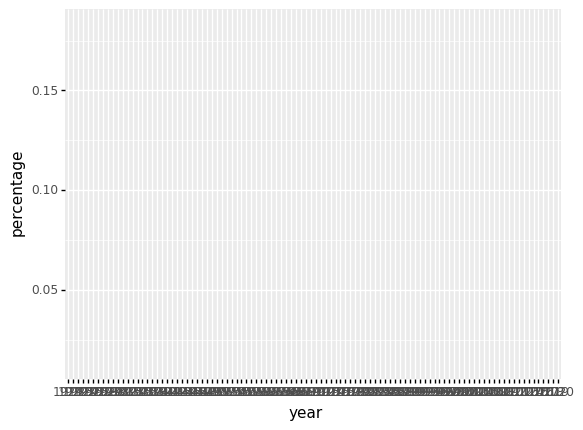

<ggplot: (183758134032)>

In [44]:
ggplot(key_distro_1, aes(x = "year", y = "percentage", fill = "year")) + geom_line()

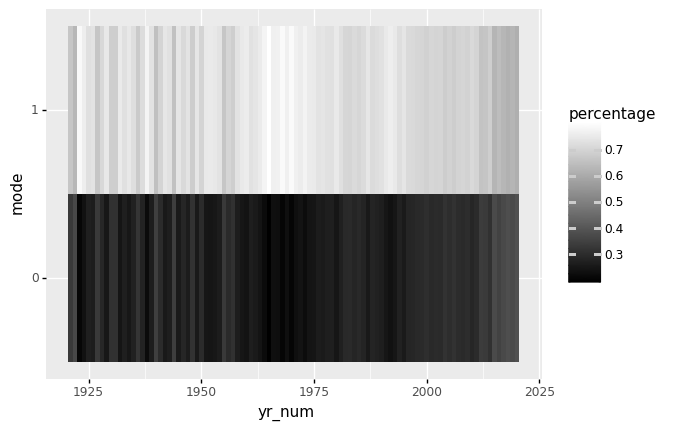

<ggplot: (183759040344)>

In [99]:
(ggplot(mode_distro_1, aes(x = "yr_num", y = "mode", fill = "percentage")) 
 + geom_tile()
 + scale_fill_gradient(low='black',high='white')
)

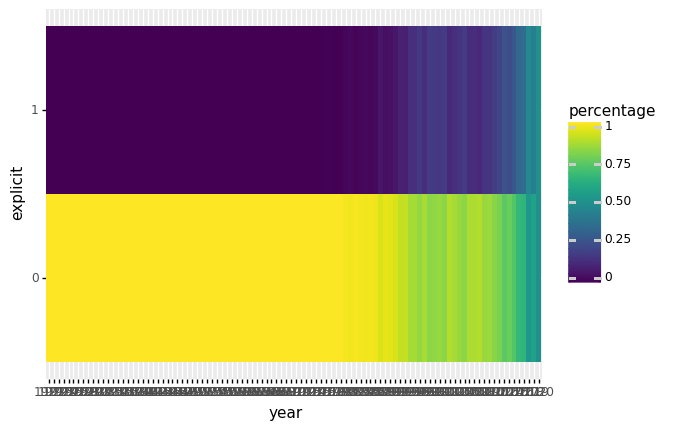

<ggplot: (183758389423)>

In [42]:
ggplot(explicit_distro_1, aes(x = "year", y = "explicit", fill = "percentage")) + geom_tile()

## 2- Can we predict if a track is major or minor given it's other characteristics?

In [ ]:
data_2 = pd.read_csv("../Data/data.csv")
data_2.head()

## 3- Can we classify the songs into different "contexts" in which they would be played?

In [ ]:
data_3 = pd.read_csv("../Data/data.csv")
data_3.head()